In [306]:
import yfinance as yf
import matplotlib.pyplot as plt

In [694]:
spy_ticker = 'SPY'

start_date = '2021-01-01'
end_date = '2024-12-31'

In [696]:
spy_df = yf.download(tickers=spy_ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [697]:
spy_df.index

DatetimeIndex(['2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-11', '2021-01-12', '2021-01-13',
               '2021-01-14', '2021-01-15',
               ...
               '2024-12-16', '2024-12-17', '2024-12-18', '2024-12-19',
               '2024-12-20', '2024-12-23', '2024-12-24', '2024-12-26',
               '2024-12-27', '2024-12-30'],
              dtype='datetime64[ns]', name='Date', length=1004, freq=None)

In [698]:
#  20 day MA
window_size = 20

spy_df['SMA'] = spy_df['Adj Close'].rolling(window=window_size).mean()

spy_df['EMA'] = spy_df['Adj Close'].ewm(span=window_size, adjust=False).mean()

In [699]:
# 14 day rsi period
rsi_period = 14

delta = spy_df['Adj Close'].diff()

gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

avg_gain = gain.rolling(window=rsi_period, min_periods=rsi_period).mean()
avg_loss = loss.rolling(window=rsi_period, min_periods=rsi_period).mean()

avg_gain = avg_gain.combine_first(gain.ewm(span=rsi_period, adjust=False).mean())
avg_loss = avg_loss.combine_first(loss.ewm(span=rsi_period, adjust=False).mean())

rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))

spy_df['RSI'] = rsi

In [704]:
oversold_threshold = 40
overbought_threshold = 60
spy_df['Buy signal'] = (spy_df['RSI'] < oversold_threshold) & (spy_df['RSI'].shift(1) >= oversold_threshold)
spy_df['Sell signal'] = (spy_df['RSI'] > overbought_threshold) & (spy_df['RSI'].shift(1) <= overbought_threshold)
buy_days = spy_df[spy_df['Buy signal']]
sell_days = spy_df[spy_df['Sell signal']]

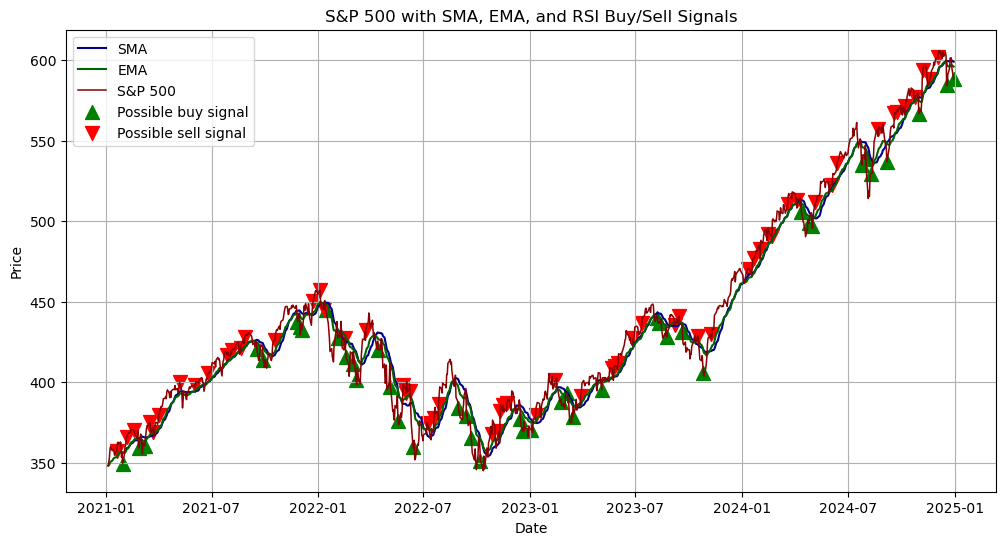

In [705]:
plt.figure(figsize=(12, 6))

# Plot SMA, EMA, and Adjusted Close
plt.plot(spy_df['SMA'].index, spy_df['SMA'], color="darkblue", label="SMA")
plt.plot(spy_df['EMA'].index, spy_df['EMA'], color="darkgreen", label="EMA")
plt.plot(spy_df['Adj Close'].index, spy_df['Adj Close'], color="darkred", label="S&P 500", linewidth=1.1)

# Plot Buy Signals (Green Arrows)
plt.scatter(spy_df.index[spy_df['Buy signal']], 
            spy_df['Adj Close'][spy_df['Buy signal']], 
            marker='^', color='green', label='Possible buy signal', s=100)

# Plot Sell Signals (Red Arrows)
plt.scatter(spy_df.index[spy_df['Sell signal']], 
            spy_df['Adj Close'][spy_df['Sell signal']], 
            marker='v', color='red', label='Possible sell signal', s=100)

# Plot Configuration
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("S&P 500 with SMA, EMA, and RSI Buy/Sell Signals")
plt.grid(True)
plt.show()

In [735]:
initial_cash = 10000000
cash = initial_cash
position = 0
portfolio_value = 0
portfolio = []
transaction_fee = 5000
for i in range(len(spy_df)):
    price = df['Adj Close'].iloc[i]
    if spy_df['Buy signal'].iloc[i]:
        cash -= transaction_fee
        position += cash * 0.75 / price
        cash *= 0.25
    elif spy_df['Sell signal'].iloc[i]:
            cash += position * price - transaction_fee
            position = 0
    portfolio_value = cash + position * price
    portfolio.append(portfolio_value)
spy_df['Portfolio_Value'] = portfolio

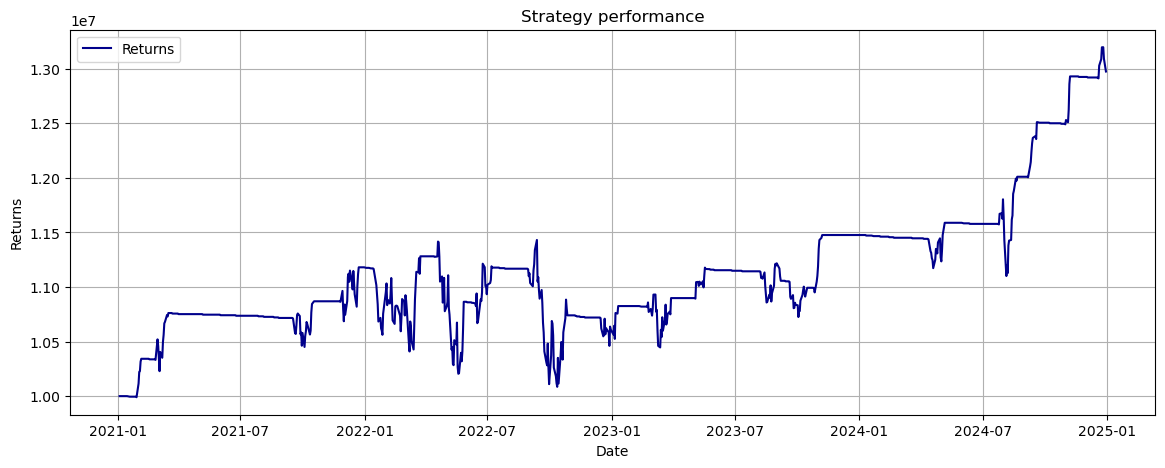

Total Return: 29.74%


In [737]:
plt.figure(figsize=(14, 5))
plt.plot(spy_df['Portfolio_Value'], label='Returns', color='darkblue')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Strategy performance')
plt.grid(True)
plt.legend()
plt.show()

total_return = (spy_df['Portfolio_Value'].iloc[-1] - initial_cash) / initial_cash * 100
print(f"Total Return: {total_return:.2f}%")

In [739]:
total_return = spy_df['Portfolio_Value'].iloc[-1] / spy_df['Portfolio_Value'].iloc[0]
num_years = (spy_df.index[-1] - spy_df.index[0]).days / 365
annual_return = total_return ** (1 / num_years) - 1
returns = spy_df['Portfolio_Value'].pct_change().dropna()
risk = returns.std() * np.sqrt(252)
risk_free = 0.0479
sr = (annual_return - risk_free) / risk
print(f"Expected returns: {annual_return:.2%}")
print(f"Risk: {risk:.2%}")
print(f"Sharpe Ratio: {sr:.2f}")

Expected returns: 6.74%
Risk: 10.62%
Sharpe Ratio: 0.18


Max Drawdown: -11.77%


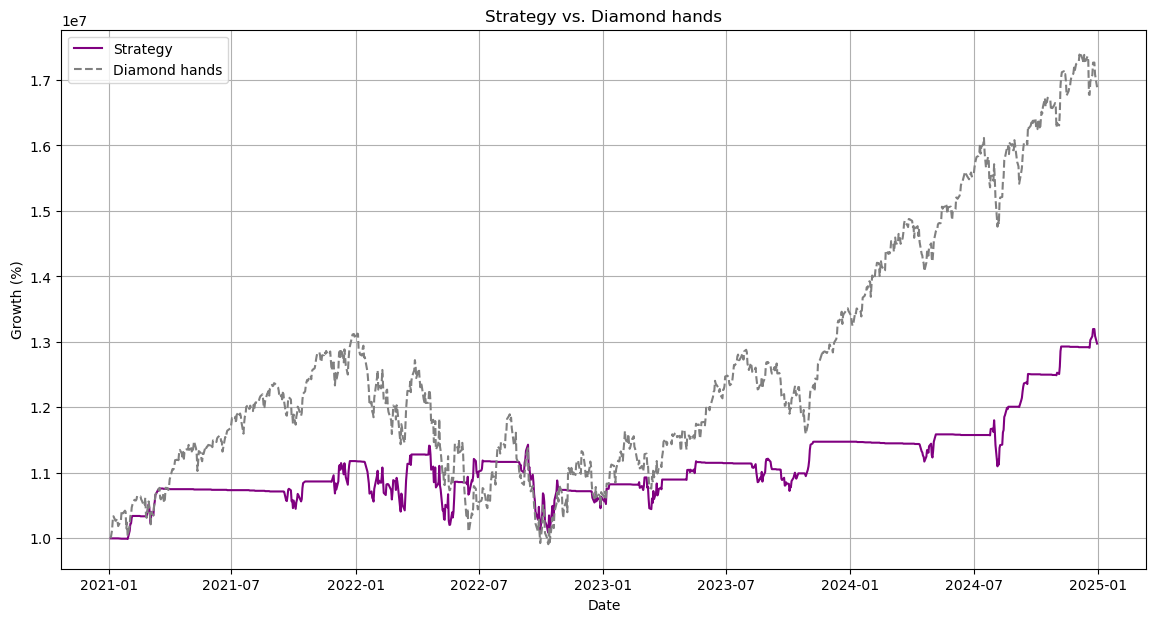

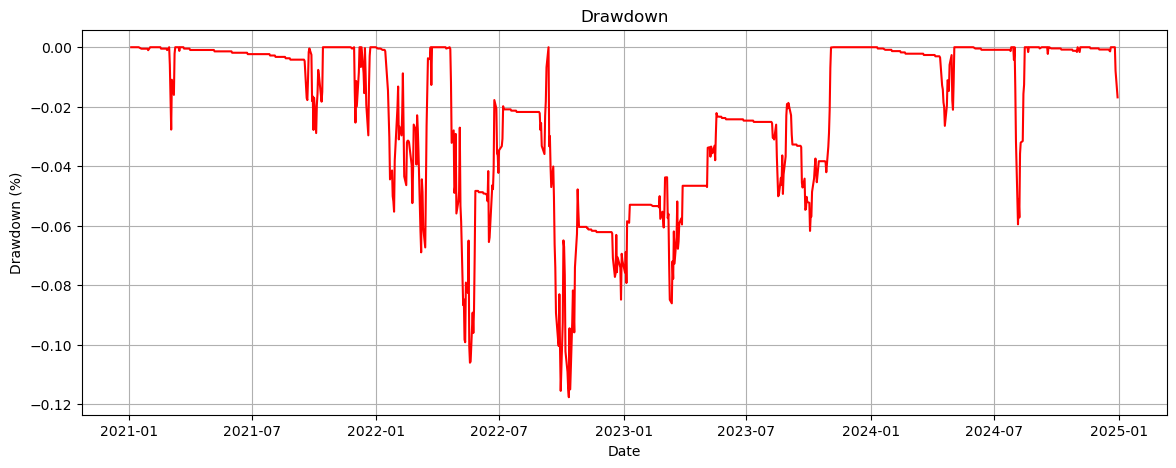

In [743]:
rolling_max = spy_df['Portfolio_Value'].cummax()
drawdown = (spy_df['Portfolio_Value'] - rolling_max) / rolling_max
max_drawdown = drawdown.min()
print(f"Max Drawdown: {max_drawdown:.2%}")

spy_df['Buy_and_Hold'] = spy_df['Adj Close'] / spy_df['Adj Close'].iloc[0] * spy_df['Portfolio_Value'].iloc[0]

plt.figure(figsize=(14, 7))
plt.plot(spy_df['Portfolio_Value'], label='Strategy', color='purple')
plt.plot(spy_df['Buy_and_Hold'], label='Diamond hands', color='gray', linestyle='--')
plt.title('Strategy vs. Diamond hands')
plt.xlabel('Date')
plt.ylabel('Growth (%)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(drawdown, color='red')
plt.title('Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.grid(True)
plt.show()